# **Multi-Stage Classification with Random Forest: Deleted vs Non-Deleted and Normal vs Amplified**

This notebook focuses on implementing and evaluating a **multi-stage classification pipeline** using **Random Forest** for both stages. The pipeline is designed to handle two sequential classification tasks: **Deleted vs Non-Deleted (Stage 1)** and **Normal vs Amplified (Stage 2)**. The objective is to optimize the performance of the pipeline by leveraging the strengths of Random Forest for handling class imbalances and complex relationships in the data.

---

### **Workflow**

1. **Stage 1: Deleted vs Non-Deleted**
   - Train and evaluate a Random Forest classifier to distinguish between Deleted and Non-Deleted classes.
   - Generate **confusion matrices** and **classification reports** to analyze performance, particularly focusing on recall for the Deleted class to minimize false negatives.
   - Handle class imbalance using techniques like class weighting.

2. **Stage 2: Normal vs Amplified (Non-Deleted Data)**
   - Use the predictions from Stage 1 to filter Non-Deleted data and train a Random Forest classifier to classify Normal and Amplified cases.
   - Evaluate the model with **confusion matrices** and **classification reports** to assess precision, recall, and F1-score.
   - Focus on balanced performance for both Normal and Amplified classes.

3. **Performance Analysis**
   - Compare the results across both stages to ensure optimal performance in the multi-stage pipeline.
   - Analyze key metrics such as recall, precision, and F1-score to identify potential improvements in each stage.

4. **Pipeline Deployment**
   - Integrate the trained Random Forest models into a sequential pipeline for end-to-end classification.
   - Evaluate the overall pipeline performance, ensuring it meets the desired accuracy and recall thresholds for each task.

---

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

### Loading the Combined DataFrame

In [2]:
combined_data = pd.read_pickle('combined_data.pkl')

### **Stage 1: Deleted vs Non-Deleted**

Stage 1 Classification Report (Deleted vs Non-Deleted):
              precision    recall  f1-score   support

     deleted       0.28      0.70      0.40     31486
 non-deleted       0.97      0.86      0.91    402511

    accuracy                           0.85    433997
   macro avg       0.63      0.78      0.65    433997
weighted avg       0.92      0.85      0.87    433997



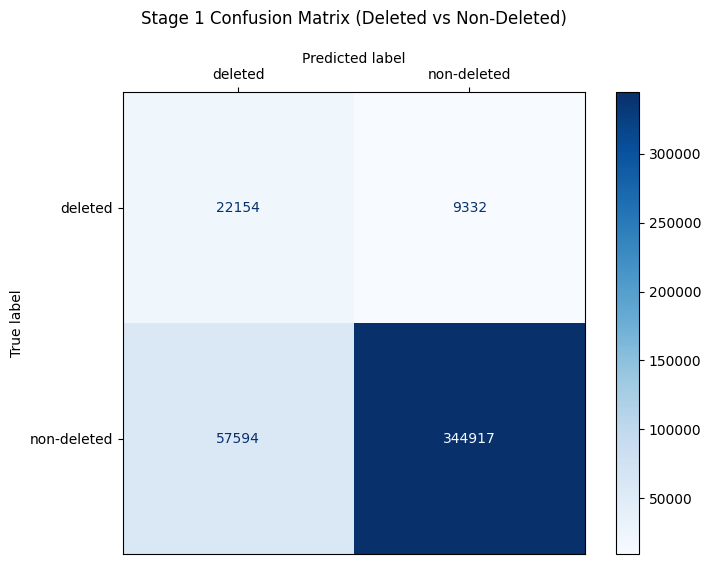

In [17]:
# **Prepare Data for Stage 1**

# Map `status` column to 'deleted' or 'non-deleted'
stage1_data = combined_data.copy()
stage1_data['status'] = stage1_data['status'].apply(lambda x: 'non-deleted' if x != 'deleted' else 'deleted')

# Split features and labels
X_stage1 = stage1_data.drop(columns=['status'])
y_stage1 = stage1_data['status']

# Encode labels
le_stage1 = LabelEncoder()
y_stage1_encoded = le_stage1.fit_transform(y_stage1)  # 'deleted' -> 0, 'non-deleted' -> 1

# Split data into training and test sets
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
    X_stage1, y_stage1_encoded, test_size=0.2, stratify=y_stage1_encoded, random_state=42
)

# **Train Random Forest Model for Stage 1**

rf_stage1 = RandomForestClassifier(
    class_weight='balanced', # Handle class imbalance
    random_state=42,       # Reproducibility
    n_jobs=-1              # Use all available cores
)

rf_stage1.fit(X_train_stage1, y_train_stage1)

# **Evaluate Stage 1**

# Predict on the test set
y_pred_stage1 = rf_stage1.predict(X_test_stage1)

# Decode labels for better interpretability
y_test_stage1_decoded = le_stage1.inverse_transform(y_test_stage1)
y_pred_stage1_decoded = le_stage1.inverse_transform(y_pred_stage1)

# Generate classification report
print("Stage 1 Classification Report (Deleted vs Non-Deleted):")
print(classification_report(y_test_stage1_decoded, y_pred_stage1_decoded, target_names=le_stage1.classes_))

# Confusion matrix
cm_stage1 = confusion_matrix(y_test_stage1_decoded, y_pred_stage1_decoded, labels=le_stage1.classes_)
disp_stage1 = ConfusionMatrixDisplay(confusion_matrix=cm_stage1, display_labels=le_stage1.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_stage1.plot(ax=ax, cmap='Blues')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("Stage 1 Confusion Matrix (Deleted vs Non-Deleted)", pad=20)
plt.show()



**This confusion matrix represents the performance of Stage 1 in distinguishing `deleted` cases from `non-deleted` cases. The results of this stage are critical as they determine which samples proceed to Stage 2 for further classification.**

---

#### **Key Takeaways**
- The classifier demonstrates strong performance in separating `deleted` and `non-deleted` cases, with most predictions being correct.
- Some `deleted` cases are misclassified as `non-deleted`, which will propagate errors into Stage 2.

---

#### **Class-Specific Insights**

**Deleted Class:**
- **True Positives (correctly classified as deleted):** 22,154
- **Misclassified as Non-Deleted:** 9,332
- **Recall:** High recall indicates that most `deleted` cases are correctly identified, but some errors remain.

**Non-Deleted Class:**
- **True Positives (correctly classified as non-deleted):** 344,917
- **Misclassified as Deleted:** 57,594
- **Recall:** Good recall suggests that most `non-deleted` cases are correctly identified, but a notable portion is misclassified as `deleted`.

---

### **Stage 2: Normal vs Amplified**

Stage 2 Classification Report (Normal vs Amplified, Including Deleted):


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

   amplified       0.95      1.00      0.97    857888
     deleted       0.00      0.00      0.00     19967
      normal       0.99      0.95      0.97    868425

    accuracy                           0.96   1746280
   macro avg       0.64      0.65      0.65   1746280
weighted avg       0.95      0.96      0.96   1746280



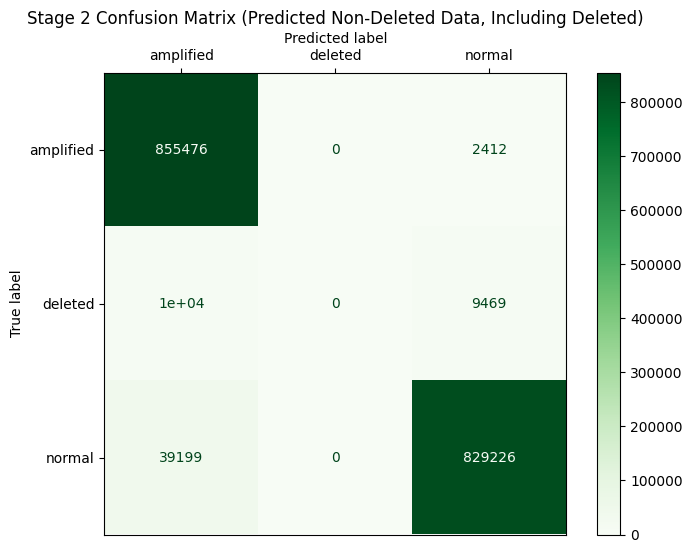

In [20]:
# **Prepare Stage 2 Training Data (Actual Non-Deleted Data)**
train_data_stage2 = combined_data[combined_data['status'] != 'deleted']

X_train_stage2 = train_data_stage2.drop(columns=['status', 'stage1_pred'], errors='ignore')  # Exclude 'stage1_pred' if it exists
y_train_stage2 = train_data_stage2['status']

# Encode labels for Stage 2
le_stage2_extended = LabelEncoder()
le_stage2_extended.fit(['normal', 'amplified', 'deleted'])  # Include 'deleted' in the label encoding
y_train_stage2_encoded = le_stage2_extended.transform(y_train_stage2)

# **Prepare Stage 2 Testing Data (Predicted Non-Deleted Data From Stage 1)**
# Filter rows predicted as 'non-deleted' by Stage 1
test_data_stage2 = combined_data[combined_data['stage1_pred'] == 1]  # Includes misclassified 'deleted'

X_test_stage2 = test_data_stage2.drop(columns=['status', 'stage1_pred'], errors='ignore')  # Exclude 'stage1_pred'
y_test_stage2 = test_data_stage2['status']

# Encode test labels with the extended label encoder
y_test_stage2_encoded = le_stage2_extended.transform(y_test_stage2)

# **Train Random Forest Model for Stage 2**
rf_stage2 = RandomForestClassifier(
    class_weight='balanced', # Handle class imbalance
    random_state=42,       # Reproducibility
    n_jobs=-1              # Use all available cores
)

# Train on actual non-deleted data
rf_stage2.fit(X_train_stage2, y_train_stage2_encoded)

# **Evaluate Stage 2**

# Predict on test data
y_pred_stage2_encoded = rf_stage2.predict(X_test_stage2)

# Decode labels for better interpretability
y_pred_stage2 = le_stage2_extended.inverse_transform(y_pred_stage2_encoded)
y_test_stage2_decoded = le_stage2_extended.inverse_transform(y_test_stage2_encoded)

# Generate classification report including 'deleted'
print("Stage 2 Classification Report (Normal vs Amplified, Including Deleted):")
print(classification_report(y_test_stage2_decoded, y_pred_stage2, target_names=le_stage2_extended.classes_))

# Generate confusion matrix
cm_stage2 = confusion_matrix(y_test_stage2_decoded, y_pred_stage2, labels=le_stage2_extended.classes_)
disp_stage2 = ConfusionMatrixDisplay(confusion_matrix=cm_stage2, display_labels=le_stage2_extended.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_stage2.plot(ax=ax, cmap='Greens')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("Stage 2 Confusion Matrix (Predicted Non-Deleted Data, Including Deleted)")
plt.show()


**This confusion matrix represents the performance of Stage 2 in classifying `normal` and `amplified` samples from the predicted non-deleted cases in Stage 1. The matrix also includes the `deleted` cases that were incorrectly classified as non-deleted by Stage 1.**

---

#### **Key Takeaways**
- Errors from Stage 1 propagate into Stage 2, particularly for the `deleted` class. In this evaluation, all `deleted` cases that entered Stage 2 were misclassified.
- The classifier effectively separates `normal` and `amplified` classes, achieving high precision and recall for both.

---

#### **Class-Specific Insights**

**Amplified Class:**
- **True Positives (correctly classified as amplified):** 855,476
- **Misclassified as Normal:** 2,412
- **Recall:** High recall indicates the majority of `amplified` cases from the predicted non-deleted data are correctly identified.

**Deleted Class:**
- **True Positives (correctly classified as deleted):** 0
- **Misclassified as Amplified:** 10,000
- **Misclassified as Normal:** 9,469
- The classifier is not designed to handle the `deleted` class in this stage, resulting in all deleted cases being misclassified.

**Normal Class:**
- **True Positives (correctly classified as normal):** 829,226
- **Misclassified as Amplified:** 39,199
- **Recall:** High recall for `normal` cases demonstrates strong performance in identifying these samples.

---

### **Pipeline**

#### **Pipeline Workflow: Multi-Stage Classification**

---

#### **Stage 1: Deleted vs Non-Deleted Classification**
1. **Input:** Full dataset containing `normal`, `amplified`, and `deleted` samples.
2. **Task:** Classify each sample as either:
   - **`deleted`**: Sent to the final results as `deleted`.
   - **`non-deleted`**: Passed to Stage 2 for further classification.
3. **Output:** 
   - Predicted labels (`deleted` or `non-deleted`).
   - Split data into `predicted_deleted` and `predicted_non_deleted` subsets.

---

#### **Stage 2: Normal vs Amplified Classification**
1. **Input:** Samples predicted as `non-deleted` from Stage 1.
2. **Task:** Classify these samples further into:
   - **`normal`**
   - **`amplified`**
3. **Output:**
   - Predicted labels (`normal` or `amplified`) for non-deleted samples.

---

#### **Combining Results**
1. **Deleted Cases:** Assign the label `deleted` for all samples predicted as `deleted` in Stage 1.
2. **Non-Deleted Cases:** Use predictions from Stage 2 to assign `normal` or `amplified` labels.
3. **Final Dataset:**
   - Combine `deleted` predictions from Stage 1 with `normal` and `amplified` predictions from Stage 2.
   - Evaluate the pipeline on all classes: `normal`, `amplified`, and `deleted`.

---

Full Pipeline Classification Report:
              precision    recall  f1-score   support

   amplified       0.95      0.87      0.91    997434
     deleted       0.35      0.87      0.50    157432
      normal       0.99      0.83      0.90   1015119

    accuracy                           0.85   2169985
   macro avg       0.76      0.86      0.77   2169985
weighted avg       0.92      0.85      0.87   2169985



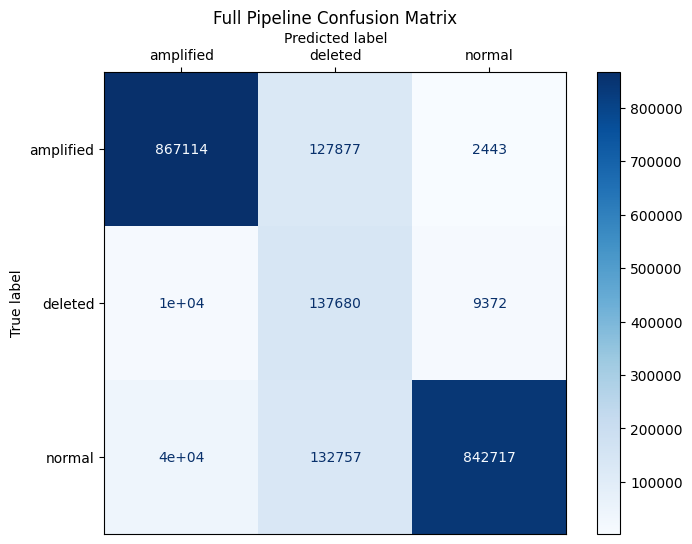

In [23]:
# **Stage 1 Predictions**
# Predict deleted vs non-deleted
stage1_predictions = rf_stage1.predict(combined_data.drop(columns=['status']))
combined_data['stage1_pred'] = stage1_predictions

# Split data based on Stage 1 predictions
predicted_deleted = combined_data[combined_data['stage1_pred'] == 0].copy()
predicted_non_deleted = combined_data[combined_data['stage1_pred'] == 1].copy()

# **Stage 2 Predictions**
# Test data includes all predicted non-deleted cases
X_stage2 = predicted_non_deleted.drop(columns=['status', 'stage1_pred'])
y_stage2 = predicted_non_deleted['status']

# Encode labels for all statuses including 'deleted'
le_pipeline = LabelEncoder()
le_pipeline.fit(['normal', 'amplified', 'deleted'])

# Predict Stage 2 labels
stage2_predictions = rf_stage2.predict(X_stage2)

# Assign Stage 2 predictions to predicted non-deleted samples
predicted_non_deleted['stage2_pred'] = le_pipeline.inverse_transform(stage2_predictions)

# Assign 'deleted' to predicted deleted samples
predicted_deleted['final_pred'] = 'deleted'

# Assign Stage 2 predictions to final_pred for non-deleted samples
predicted_non_deleted['final_pred'] = predicted_non_deleted['stage2_pred']

# **Combine Results**
pipeline_results = pd.concat([predicted_deleted, predicted_non_deleted])

# Ground truth and predictions
y_true_pipeline = pipeline_results['status']
y_pred_pipeline = pipeline_results['final_pred']

# **Evaluate Full Pipeline**
print("Full Pipeline Classification Report:")
print(classification_report(y_true_pipeline, y_pred_pipeline, target_names=le_pipeline.classes_))

# Confusion Matrix
cm_pipeline = confusion_matrix(y_true_pipeline, y_pred_pipeline, labels=le_pipeline.classes_)
disp_pipeline = ConfusionMatrixDisplay(confusion_matrix=cm_pipeline, display_labels=le_pipeline.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_pipeline.plot(ax=ax, cmap='Blues')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("Full Pipeline Confusion Matrix")
plt.show()


### **Key Takeaways**

- The **accuracy** of the pipeline is **85%**, with high performance in classifying amplified and normal cases but notable challenges in handling deleted cases.
- The **deleted class** achieves a high recall (ability to identify most deleted cases) but suffers from low precision due to many misclassifications.
- Errors in Stage 1 (Deleted vs. Non-Deleted) propagate into Stage 2, significantly affecting the overall performance on the deleted class.

---

### **Class-Specific Insights**

#### **Amplified Class**
- **True Positives** (correctly classified as amplified): 867,114
- **Misclassified as Deleted**: 127,877
- **Misclassified as Normal**: 2,443
- **Precision**: High precision reflects minimal misclassification into other classes.
- **Recall**: 87%, indicating that most amplified cases are correctly identified.

#### **Deleted Class**
- **True Positives** (correctly classified as deleted): 137,680
- **Misclassified as Amplified**: 10,000
- **Misclassified as Normal**: 9,372
- **Precision**: Low precision reflects many misclassifications into this class.
- **Recall**: High recall (87%) indicates that most true deleted cases are detected, even if they overlap with other classes.

#### **Normal Class**
- **True Positives** (correctly classified as normal): 842,717
- **Misclassified as Amplified**: 40,000
- **Misclassified as Deleted**: 132,757
- **Precision**: Nearly perfect precision highlights strong performance in classifying normal cases.
- **Recall**: 83%, showing some misclassifications into other categories.

---